In [1]:
import json
import pandas as pd

## Data 불러오기

In [2]:
file_path = './outputdump.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.loads(file.read())
    print(type(data))
    print(data)


<class 'list'>
[{'quality': 1, '_id': {'$oid': '640803455de52bf849b8d9ba'}, '_idx': 1, 'cat1': '정치', 'cat2': '대통령실', 'title': '[뉴스포커스] 윤대통령, 4월말 미국 국빈 방문…한미 밀착 가속화', 'description': '윤석열 대통령이 다음 달 말 미국에서 바이든 대통령과 정상회담을 갖습니다. 이번 방미는 국빈방문으로 대통령실은 역사적 전기가 될 …', 'press': '연합뉴스TV', 'link': 'https://n.news.naver.com/mnews/article/422/0000587594?sid=100', 'publish_date': '2023-03-08 10:48:03', 'full_text': '<출연 : 김재천 서강대학교 국제대학원 교수>윤석열 대통령이 다음 달 말 미국에서 바이든 대통령과 정상회담을 갖습니다. 이번 방미는 국빈방문으로 대통령실은 역사적 전기가 될 것이라 밝혔는데요. 이달 중엔 한일정상회담을 위해 일본 방문도 유력하게 검토되고 있어 한미일 삼각 협력이 가속화될 것으로 보입니다. 관련 내용들, 김재천 서강대학교 국제대학원 교수와 함께 이야기 나눠보겠습니다. 어서 오세요. <질문 1> 먼저, 어젯밤 늦게 워싱턴포스트에서 가장 먼저 보도를 했는데요. 백악관은 윤대통령의 미국 국빈방문 일정이 4월 26일로 예정됐으며, 국빈 만찬이 포함된다고 발표했습니다. 윤 대통령이 취임 이후에 한미정상회담에 나서는 것이 벌써 세 번째인데요. 이번엔 국빈 방문입니다. 이번 한미정상회담의 의미는 뭐라고 보시나요? <질문 1-1> 국빈 방문은 2011년 이명박 전 대통령의 국빈 방문 이후 12년 만이고, 바이든 정부 출범 후 국빈 형식으로 미국을 방문했던 정상도 윤 대통령이 두 번째가 된다고 하는데, 국빈 방문의 의미도 좀 짚어주시죠. <질문 2> 아직 확정이 되진 않았지만, 미 의회에서 연설도 관측되고 있는데요. 보통 외국 정상이 국빈 방문을 하면 미

In [1]:
from pymongo import MongoClient
from dotenv import load_dotenv
import os

load_dotenv(verbose=True,dotenv_path='./env')

# mongoDB 설정
mongo_host = "localhost"
mongo_port = 27020
mongo_user = "churros"
mongo_passwd = "A503"
mongo_db_name = "newsdb"
mongo_client = MongoClient(host=mongo_host, port=mongo_port, username=mongo_user, password=mongo_passwd)


db = mongo_client[mongo_db_name]
collection = db['newsCol']


In [2]:
list(collection.find({"cat1": "연예"}).sort("_idx", -1))
data = list(collection.find())

## Quality Measurement
- 제목길이, 본문길이, 기자 정보(skip), 섹션 정보, 콘텐츠 타입 정보(skip), 이미지 여부 -> feature로 활용
- 추가적인 feature를 생성해도 될듯 (단어 갯수, 기타 등등...)
- 위의 features 활용하여 기사의 quality 측정
- 우선은 다중 회귀 활용 예정

In [35]:
df_raw = pd.DataFrame(data)
df = df_raw
# 제목 길이 변수
df['title_len'] = df['title'].apply(len)
# 본문 길이 변수
df['full_text_len'] = df['full_text'].apply(len)
# 언론사 정보???
# 카테고리 정보 (one hot encoding)
category_dummies = pd.get_dummies(df['cat1'])
df = pd.concat([df, category_dummies], axis=1)
category_dummies2 = pd.get_dummies(df['cat2'])
df = pd.concat([df, category_dummies2], axis=1)
# 콘텐츠 타입 정보? pass

# 이미지 여부(boolean)
df['img'] = df['img_src'].apply(lambda x: 1 if x != "" else 0)
df_quality = df.iloc[:,12:]
x = df_quality.iloc[:,:-1]
# 값의 경우 labeling 이 진행되어야 한다
y = df_raw['quality']
print(df_quality.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   title_len      15 non-null     int64
 1   full_text_len  15 non-null     int64
 2   정치             15 non-null     uint8
 3   대통령실           15 non-null     uint8
 4   img            15 non-null     int64
dtypes: int64(3), uint8(2)
memory usage: 518.0 bytes
None


In [131]:
# 다중 회귀 분석
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
mlr = LinearRegression()
mlr.fit(x_train, y_train)
print(mlr.score(x_train, y_train))
# 이제 mlr.predict(features) 에 값을 넣으면 결과값이 나온다
# 이 결과값을 기준으로 특정 점수 이하일 경우 분석에서 제외 또는 출력에서 제외

0.029603314303728312


In [44]:
y_predict = mlr.predict(x_test)
y_predict

array([0.56582092, 0.50240706, 0.72315107])

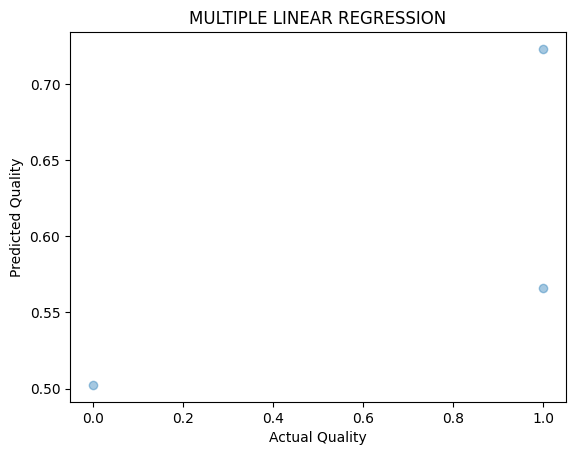

In [45]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

## 데이터 전처리 및 Token화
- Stemming 및 외래어 부분 참조 [link](https://colab.research.google.com/drive/1FfhWsP9izQcuVl06P30r5cCxELA1ciVE?usp=sharing#scrollTo=mQtv-RQDAGtF)
- 불용어 처리 코드 참조 [link](https://velog.io/@jochedda/NLP-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%A0%84%EC%B2%98%EB%A6%AC)
- 모델별 결과 참조 [link](https://dacon.io/codeshare/1808)

In [3]:
from konlpy.tag import Kkma, Komoran, Okt
# 형태소 분석 library import
okt = Okt()
kkm = Kkma()
kom = Komoran()
# komoran은 빈줄이 있으면 에러가 남
# komoran.morphs("\n".join([s for s in c[:40].split("\n") if s]))

In [4]:
# 중복 반복되는 단어 정규화
# from soynlp.normalizer import *
# repeat_normalize('와하하하하하하하하하핫', num_repeats=2)

In [5]:
# mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim import corpora # 단어 빈도수 계산 패키지
from collections import Counter # 단어 등장 횟수 카운트
import pandas as pd

In [6]:
df_raw = pd.DataFrame(data)
print(df_raw.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27185 entries, 0 to 27184
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           27185 non-null  object        
 1   _idx          27185 non-null  int64         
 2   cat1          27185 non-null  object        
 3   cat2          27185 non-null  object        
 4   title         27185 non-null  object        
 5   description   27185 non-null  object        
 6   press         27185 non-null  object        
 7   link          27185 non-null  object        
 8   publish_date  27185 non-null  datetime64[ns]
 9   full_text     27185 non-null  object        
 10  img_src       27185 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 2.3+ MB
None


In [7]:
df_raw.isnull().sum()

_id             0
_idx            0
cat1            0
cat2            0
title           0
description     0
press           0
link            0
publish_date    0
full_text       0
img_src         0
dtype: int64

In [8]:
# 결측치 제거 (형태소 분석 진행시 null값이 존재하면 오류 발생)
df = df_raw.dropna(axis = 0)
df.isnull().sum()

_id             0
_idx            0
cat1            0
cat2            0
title           0
description     0
press           0
link            0
publish_date    0
full_text       0
img_src         0
dtype: int64

In [9]:
# 분석에서 제외할 데이터 제거
df.reset_index(drop = True, inplace=True) # 인덱스 초기화

In [10]:
# 토큰화 이전 불필요한 글자들 전처리
# punctuation 삭제
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } 
def clean(text):
    for p in punct_mapping:
        text = text.replace(p, punct_mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()


import re

# 불필요한 부분 삭제(이메일, url등)
def clean_str(text):
    pattern = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = r'[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub(r'\n', '.', string=text)
    return text 


동사를 원형으로 복원하도록 하겠습니다. 규칙은 다음과 같습니다.

1. NNG|NNP|NNB + XSV|XSA --> NNG|NNP|NNB + XSV|XSA + 다
2. NNG|NNP|NNB + XSA + VX --> NNG|NNP + XSA + 다
3. VV --> VV + 다
4. VX --> VX + 다

In [11]:
# 동사 원형 복원
p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                if tag != 'VX':
                    modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append((ori_sent))
    return corpus

In [13]:
# 불용어 제거 및 특정 품사만 살리기
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = set(words.split('\n'))
lemmatization = {"VV","VX","NNG","NNP","NNB","XSV","XSA","SL","XR","SN","SH","SW","MAG","NF"}

def token(txt):
    txt = clean(txt)
    txt = clean_str(txt)
    word_tokens = kom.pos(txt, join="/")
    cleared = [word for word in word_tokens if (not (word.split('/')[0] in stop_words) and word.split('/')[1] in lemmatization)]
    result = stemming_text(cleared)
    return result
df["token"] = df["full_text"].apply(token)

In [14]:
# for i in df["token"]:
#     print(' '.join(i[:20]))
print(df.token)

0        [창원/NNP, 연합뉴스/NNP, 임헌정/NNP, 기자/NNG, 윤석열/NNP, 대...
1        [창원/NNP, 연합뉴스/NNP, 임헌정/NNP, 기자/NNG, 윤석열/NNP, 대...
2        [창원/NNP, 뉴시스/NNP, 전신/NNP, 기자/NNG, 윤석열/NNP, 대통령...
3        [창원/NNP, 뉴시스/NNP, 전신/NNP, 기자/NNG, 윤석열/NNP, 대통령...
4        [창원/NNP, 뉴시스/NNP, 전신/NNP, 기자/NNG, 윤석열/NNP, 대통령...
                               ...                        
27180    [안영진/NNP, SK증권/NNP, 연구원/NNP, 금리/NNG, 인하/NNG, 목...
27181    [긴축/NNG, 강도/NNP, 표면/NNG, 지다/VV, 효과/NNG, 배가/NNG...
27182    [러스트/NNP, 한규/NNP, 빛/NNG, 기자/NNG, \t/SW, \t/SW,...
27183    [하이브/NNP, 초기/NNG, 투자자/NNG, 65/SN, 원/NNB, 투자/NN...
27184    [미래에셋증권/NNP, 본사/NNP, 전경/NNP, 미래에셋증권/NNP, 제공/NN...
Name: token, Length: 27185, dtype: object


In [ ]:
# 띄어쓰기 적용 코드, 다만 이부분은 기사 자료이기 때문에 우선 넘기기
# from pykospacing import Spacing
# spacing = Spacing()
# kospacing_sent = spacing(new_sent) 

# print(sent)
# print(kospacing_sent)

In [ ]:
# 기존 토크나이저 들의 문제점인 신조어 인식이 어려운 점을 해소하는 soynlp
# from soynlp import DoublespaceLineCorpus
# from soynlp.word import WordExtractor
# 다만 이 경우, 학습을 거쳐 토큰화 시키는것이기 때문에, 일단 생략하도록 하겠다 방식은 노션을 참고하자

## Word2Vec 구현
- 기존의 원핫 인코딩 보다 차원적인 측면에서 자원을 덜 소모하는 장점
- CBOW 와 Skip-gram 이 존재 [link](https://wooono.tistory.com/244)
  - 둘의 차이는 둘의 input 과 output 방식이 반대라는 점
  - CBOW (Continuous Bag of Words)
    - 주변 단어를 활용하여 주어진 단어를 예측
  - Skip-gram
    - 해당 단어를 보고 주변 단어를 예측
- 딥러닝을 활용한 자연어 처리 입문 참고 [link](https://wikidocs.net/50739)
- 

In [15]:
from gensim.models import Word2Vec # word2vec 모델 import

In [16]:
# model train sentences = data
model = Word2Vec(sentences=df.token, vector_size = 100, window = 8, min_count = 3, workers = 4, sg = 0) # sg = 0 이면 cbow, 1이면 skip-gram
model.wv.vectors.shape

(42785, 100)

In [17]:
# 결과 확인용
model.wv.most_similar("미국/NNP")

[('영국/NNP', 0.5766158103942871),
 ('텔아비브/NNP', 0.5240993499755859),
 ('독일/NNP', 0.5075869560241699),
 ('현지/NNG', 0.49116280674934387),
 ('캐나다/NNP', 0.4710409939289093),
 ('WSJ/SL', 0.4699198603630066),
 ('버지니아/NNP', 0.4659435749053955),
 ('미/NNP', 0.4656926989555359),
 ('유럽/NNP', 0.4580058157444),
 ('브뤼셀/NNP', 0.45718154311180115)]

### 시각화

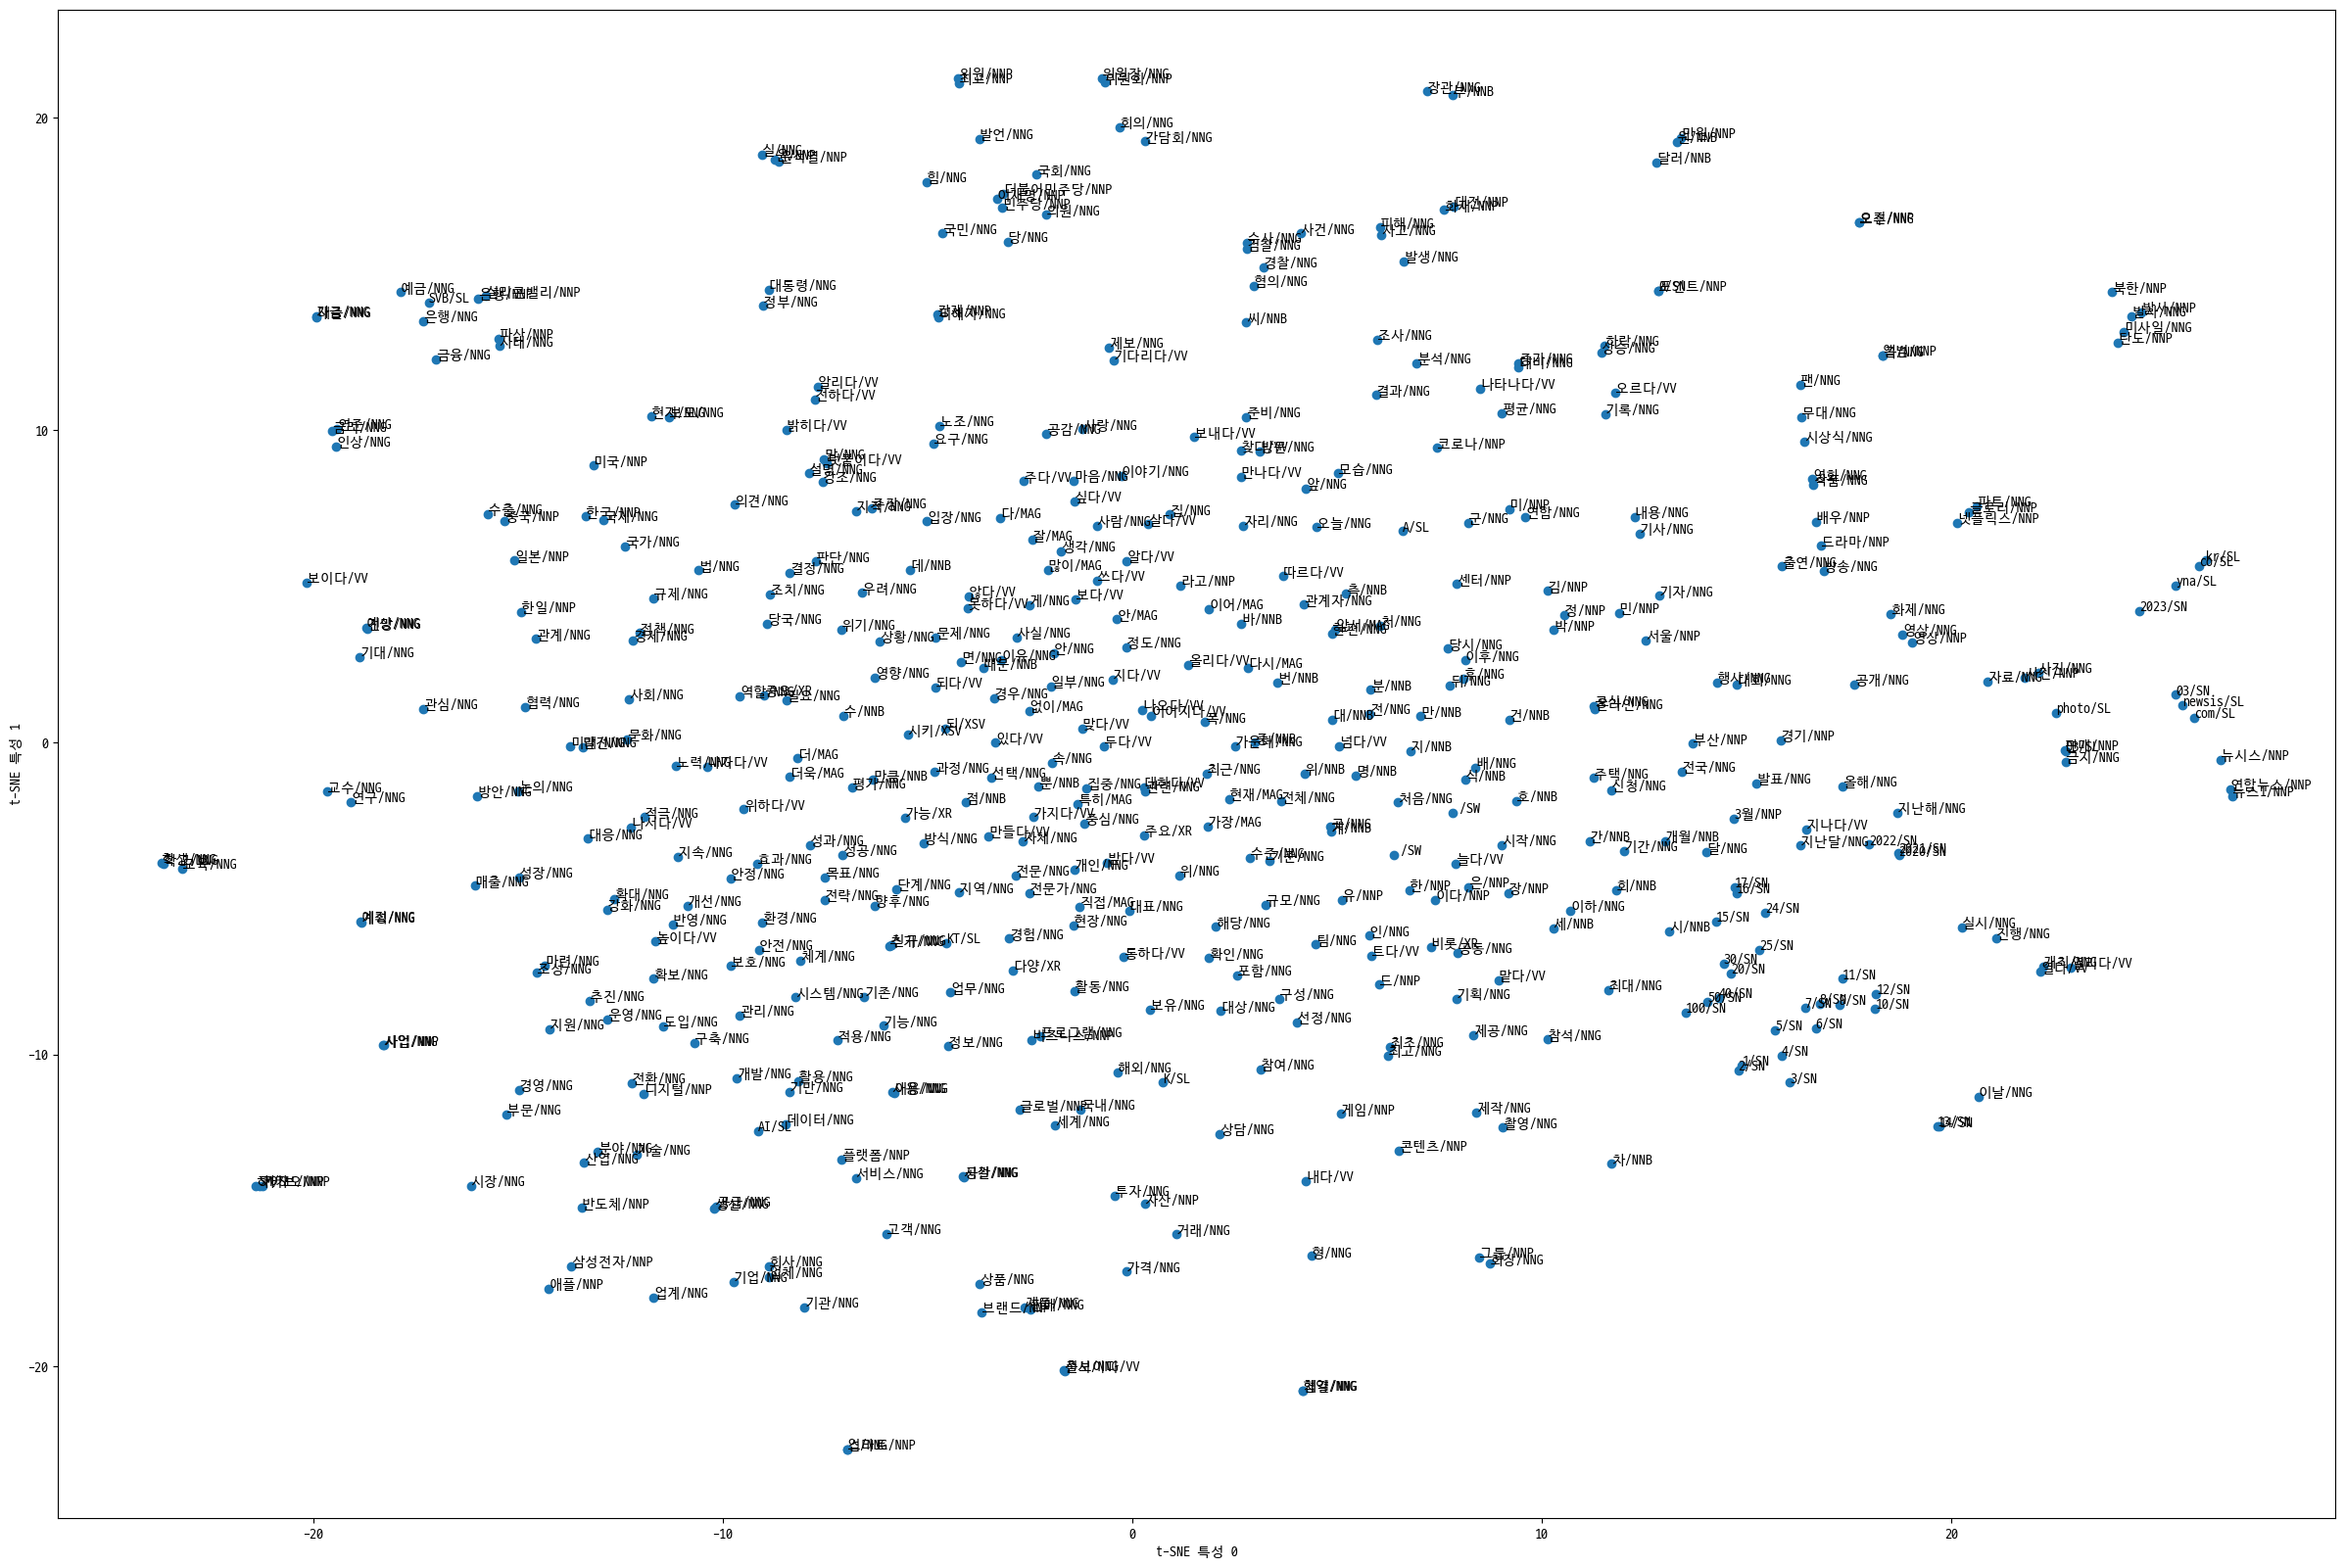

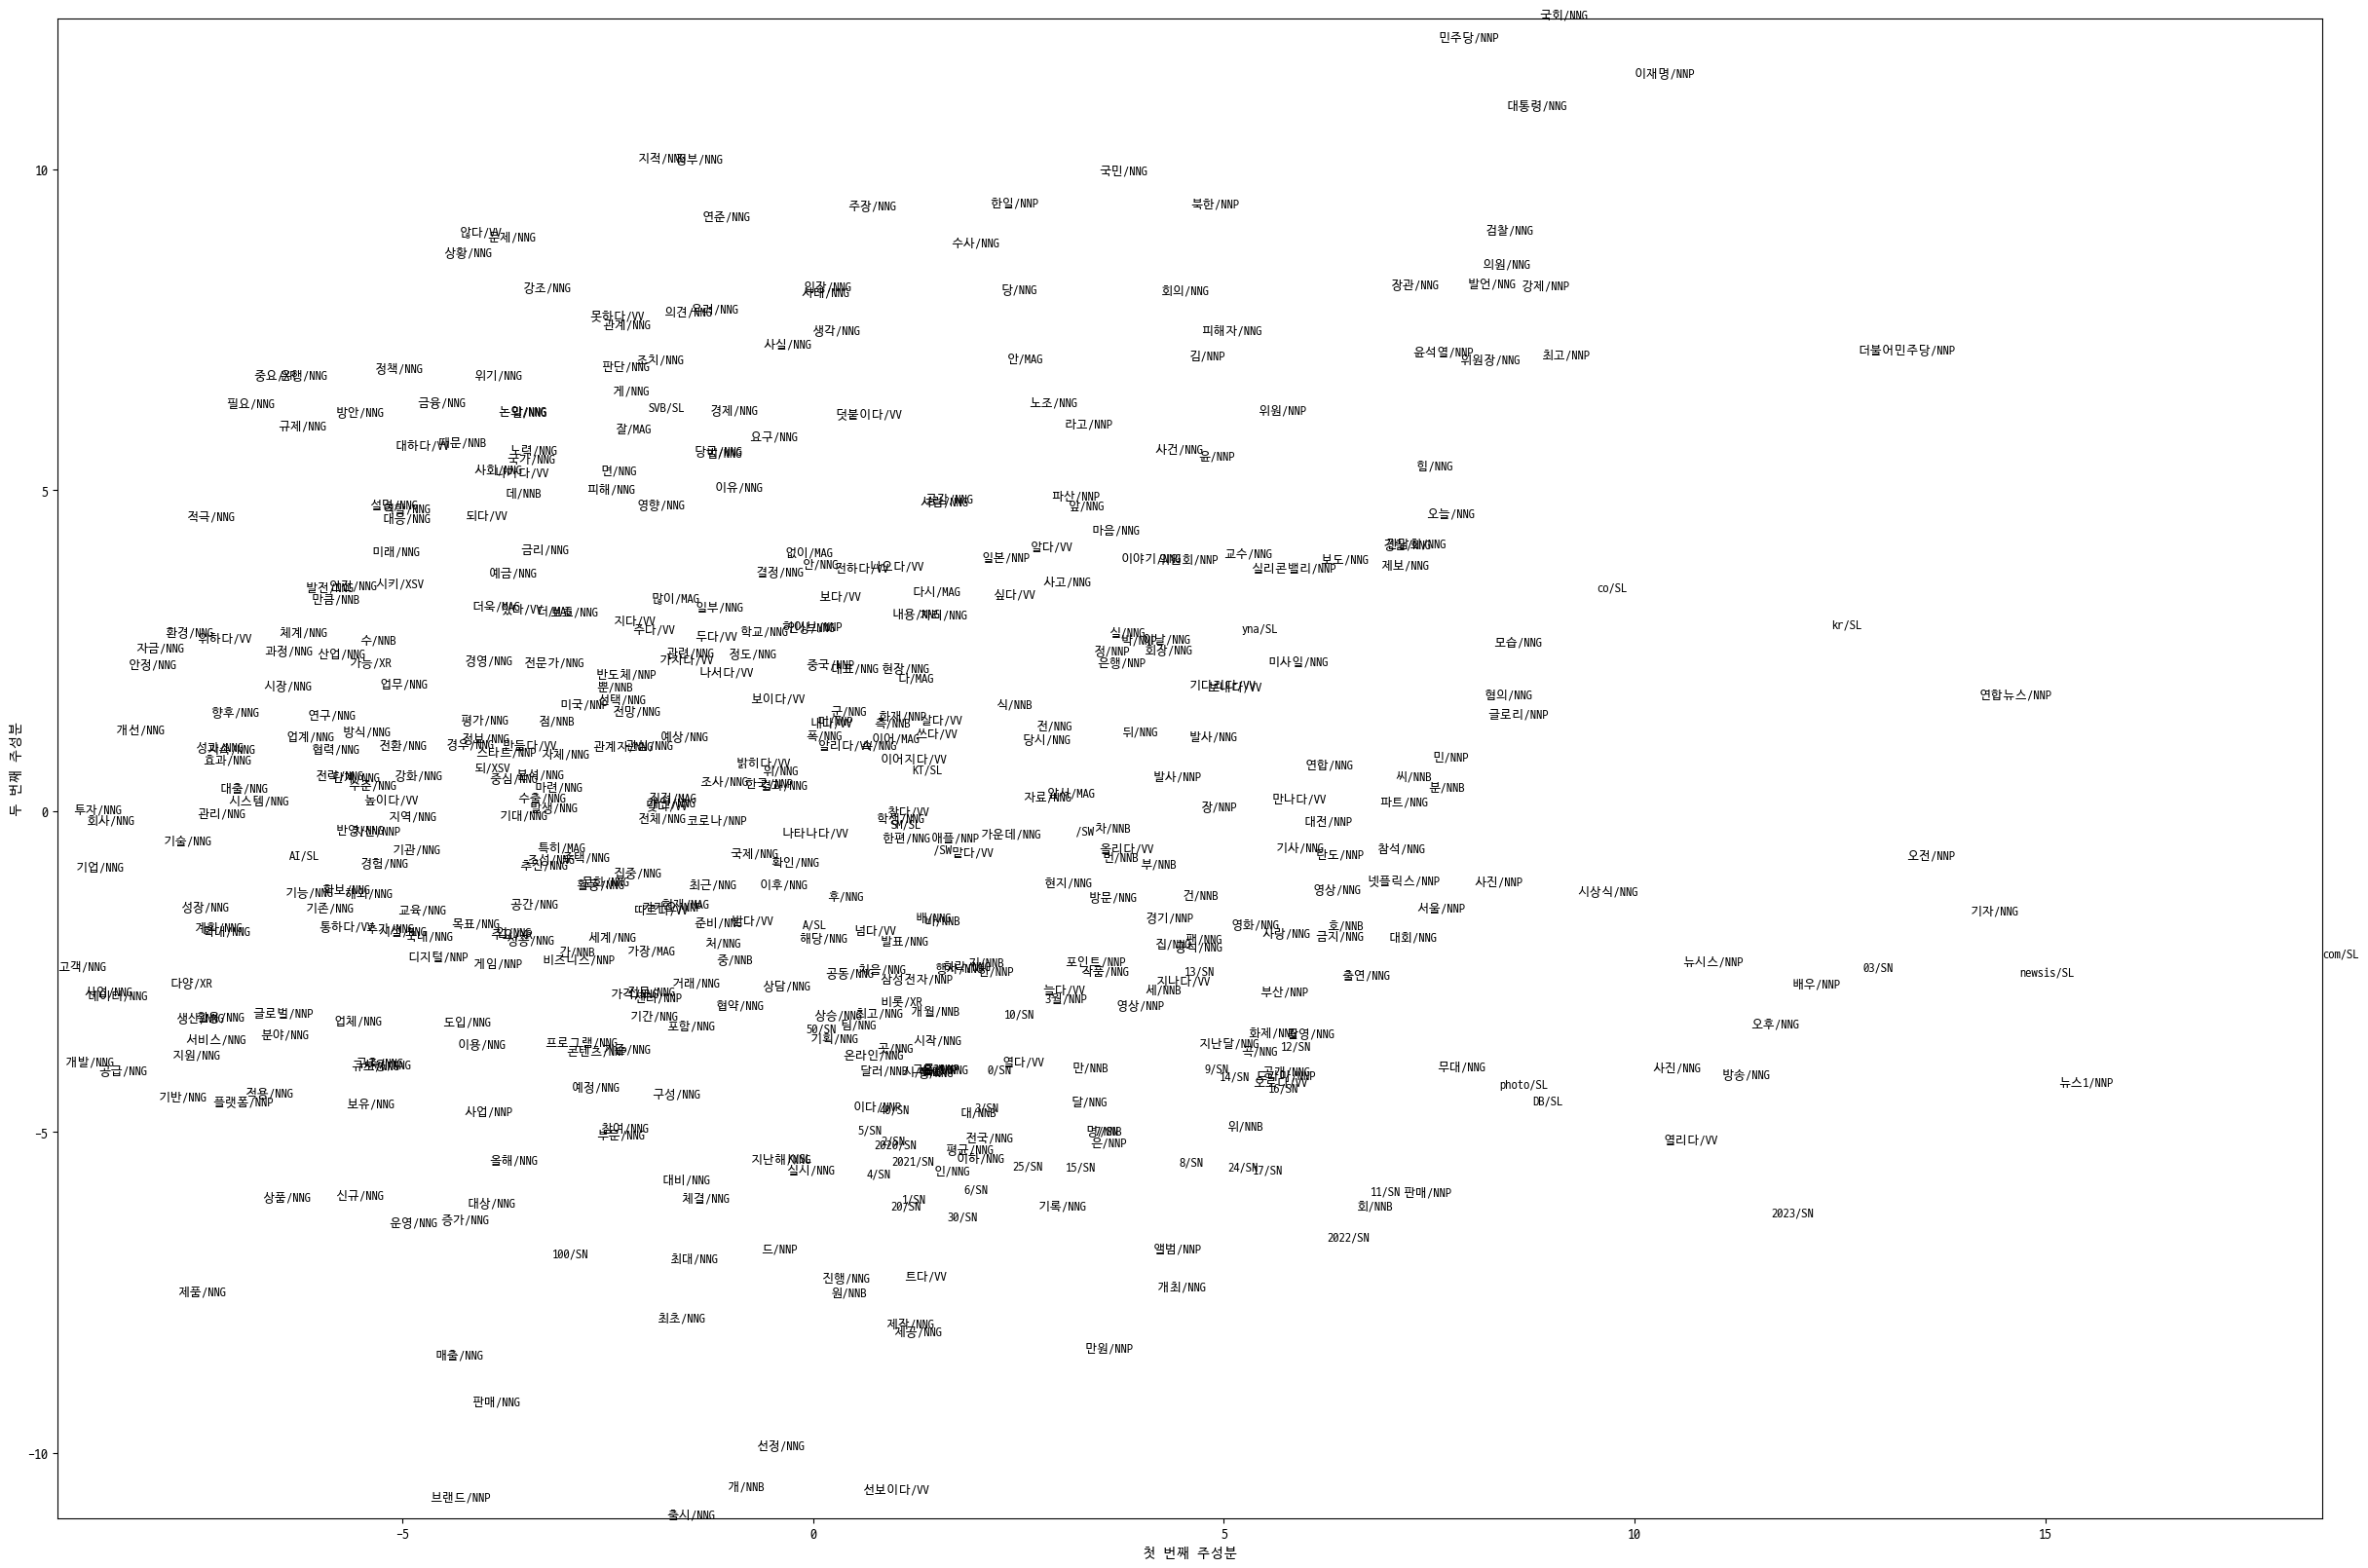

In [18]:
#visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import KeyedVectors

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family='D2Coding')

def show_tsne():
    tsne = TSNE(n_components=2)
    X = tsne.fit_transform(X_show)

    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])
    fig = plt.figure()
    fig.set_size_inches(30, 20)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=10)

    plt.xlabel("t-SNE 특성 0")
    plt.ylabel("t-SNE 특성 1")
    plt.show()


def show_pca():
    # PCA 모델을 생성합니다
    pca = PCA(n_components=2)
    pca.fit(X_show)
    # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다
    x_pca = pca.transform(X_show)

    plt.figure(figsize=(30, 20))
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max())
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max())
    for i in range(len(X_show)):
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("첫 번째 주성분")
    plt.ylabel("두 번째 주성분")
    plt.show()


vocab = list(model.wv.index_to_key)
X = model.wv[vocab]

# sz개의 단어에 대해서만 시각화
sz = 500
X_show = X[:sz,:]
vocab_show = vocab[:sz]

show_tsne()
show_pca()

In [19]:
words_wp = []
embeddings_wp = []
for word in list(model.wv.index_to_key):
    embeddings_wp.append(model.wv[word])
    words_wp.append(word)

tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(np.array(embeddings_wp))

def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = plt.cm.rainbow(np.linspace(0, 1, 1))
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

tsne_plot_3d('Visualizing Embeddings using t-SNE', 'War and Peace', embeddings_wp_3d, a=0.1)

NameError: name 'np' is not defined

In [ ]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

keys = model.wv.index_to_key[:5000]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

### 추천

In [20]:
# 코사인 유사도 기반 추천
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
def get_document_vectors(document_list, model):
    document_embedding_list = []
    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in model.wv.key_to_index:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model.wv[word]
                else:
                    doc2vec = doc2vec + model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list
document_embedded = get_document_vectors(df['token'], model)

In [22]:
cosine_similarities = cosine_similarity(document_embedded, document_embedded)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (27131, 27131)


In [29]:
def recommendations(idx):
    books = df[['_idx','title', 'full_text']]

    # 입력된 인덱스와 내용 vector 값이 유사한 6개 추출
    sim_scores = cosine_similarities[idx]
    sim_scores = sim_scores.argsort()[::-1][0:11]

    # 가장 유사한 6개의 기사 인덱스
    book_indices = sim_scores.tolist()
    print(book_indices)
    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 6개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    return recommend

In [36]:
df.iloc[300][:]

_id                                      640aee5d2ad8d98d1d504d29
_idx                                                          842
cat1                                                           경제
cat2                                                        산업/재계
title                     "서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아
description     기사내용 요약 10일 공식 개점식 열어 HDC그룹 계열사 내 유통 전문 기업인 HD...
press                                                         뉴시스
link            https://n.news.naver.com/mnews/article/003/001...
publish_date                                  2023-03-10 17:30:11
full_text       기사내용 요약10일 공식 개점식 열어\n\n\n\n10일, 아이파크몰 고척점 개점식...
img_src         https://imgnews.pstatic.net/image/003/2023/03/...
token           [기사/NNG, 내용/NNG, 요약/NNG, 10/SN, 공식/NNG, 개점/NNG...
Name: 300, dtype: object

In [37]:
recommendations(300)

[300, 1622, 1286, 5213, 17213, 17061, 17769, 17218, 24345, 25766, 24237]


,_idx,title,full_text
0,842,"""서남권 쇼핑 중심지로"" 고척 아이파크몰, 오픈 두달만 170만명 찾아","기사내용 요약10일 공식 개점식 열어\n\n\n\n10일, 아이파크몰 고척점 개점식..."
1,978,전신주 까치집 제거하려다 감전..50대 숨져,▲기사 내용과 관련 없는 자료 사진전신주 위 까치집을 제거하려던 50대 남성이 감전...
2,862,"3월 셋째 주, 전국 5개 단지 총 2669가구 분양... “모두 일반 분양”",3월 셋째 주에는 전국 5개 단지 총 2669가구가 분양을 시작한다.\n\n\n\n...
3,5226,"LG 트롬 워시타워, 매년 30% 매출 성장","워시타워, 세탁기와 건조기 '일체형'의 대명사 됐다\n\n\n\nLG전자 트롬 워시..."
4,17254,"‘꽃선비 열애사’ 측 “신예은X강훈 철두철미한 배우들, 매력 터졌다”",[뉴스엔 박아름 기자] ‘꽃선비 열애사’ 신예은과 강훈이 달콤한 매력을 선보였다.B...
5,18102,영국·이스라엘처럼… 나라위해 희생한 영웅 ‘기억의 공간’ 만든다,박민식 국가보훈처장이 지난달 2일 용산 호국보훈공원 조성에 필요한 아이디어와 영감을...
6,17450,美 긴축 완화 기대…환율 장중 1300원 아래로,[서울=뉴시스] 조성봉 기자 = 코스피가 전 거래일보다 5.86포인트(0.24%) ...
7,16835,"경찰, 민노총 건설노조 지역본부 압수수색…""전임비 비리 관련""","전임비 등 강요한 전 건설노조 서남지대장…""상위 본부 압색""민주노총 ""전임비 관련 ..."
8,24514,성매매 업자에게 타인 주민증 사진 전송…대법 “무죄” 왜?,타인의 주민등록증 ‘원본 실물’이 아닌 ‘이미지 파일’을 사용한 경우 주민등록증 부...
9,25135,연어 치어 '바다로',(포항=뉴스1) 최창호 기자 = 14일 오전 경북 포항시 남구 장기면 장기천에서 열...


### 그렇다면, 유저의 활동 기록에 따른 뉴스 기사 추천을 어떻게 해야 할까?
- 카테고리 별로, 한번 나눠서 다시 거기서 유사한 놈들을 추천할까?
- 아니면, 그냥 개별 뉴스별로?
- 아니면 전체 doc의 평균값을 가져와서 나만의 vec값을 만들어서 유사한 놈들을 줄까?
- 조회 순서에 따라 

In [25]:
# 우선 이야기 했던 대로 유저의 활동기록 평균값을 가지고 돌리겠다
import numpy as np
def aggregate_vectors(read_history):
    history_vec = []
    for i in read_history:
        try:
            history_vec.append(document_embedded[i])
        except KeyError:
            continue
        
    return np.mean(history_vec, axis=0)

In [26]:
user_vector = aggregate_vectors ([1,2])
print(user_vector)

[ 0.3654617  -0.61526793  0.40360022 -0.1118138  -0.3095985  -0.0383718
  0.19081227 -0.33451995 -0.39336216 -0.09312451  1.1011965   0.17572355
 -0.57270575 -0.02253849 -0.15417075  0.35935807  0.5199645  -0.5967827
 -0.6746872   0.37893388  0.47336525 -0.6880171  -0.06141684 -0.46539855
  0.04257203 -0.5956647   0.01488893  0.05516362 -0.2597107   0.33955076
  0.08900912  0.06464927  0.9359683  -1.2542783  -0.57677823 -0.1835932
 -1.3849429  -0.32325527 -0.19833161 -0.7041842  -0.6458757   0.16960675
  0.6075808   0.16790298  0.4667795   0.77177405 -0.8430334   0.16045651
 -0.35200265  0.07861745 -0.3516343  -0.32794523 -0.43628222 -0.9755279
 -0.14521657  0.21045282  1.0779073   0.37833333 -0.24368107  1.4660676
 -0.17607808 -0.08561587  0.48297387  0.09328708 -0.802694    0.25378528
 -0.07841612  0.06052805 -1.3299108   0.20446405 -0.52183735 -0.44892555
  0.48284975  0.12733671  0.7435077  -0.14670204  0.6802699  -1.1485416
 -0.9028646   0.33119452  0.4160095  -0.84824985 -0.04565

In [27]:
def user_recommendations(user):
    books = df[['_idx','title', 'full_text']]

    # 입력된 인덱스와 내용 vector 값이 유사한 6개 추출
    user = user_vector.reshape(1,-1)
    sim_scores = cosine_similarity(document_embedded, user).ravel()
    sim_scores = sim_scores.argsort()[::-1][0:6]
    # 가장 유사한 6개의 기사 인덱스
    book_indices = sim_scores.tolist()
    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 6개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    return recommend

In [28]:
user_recommendations(user_vector)

,_idx,title,full_text
0,783,해군사관학교 졸업 및 임관식 참석한 김건희 여사,[창원=뉴시스] 전신 기자 = 윤석열 대통령 부인 김건희 여사가 10일 경남 창원 ...
1,6,신임 장교들과 기념촬영 하는 윤석열 대통령-김건희 여사,[창원=뉴시스] 전신 기자 = 윤석열 대통령과 부인 김건희 여사가 10일 경남 창원...
2,8,해군사관생도들과 악수하는 윤석열 대통령,[창원=뉴시스] 전신 기자 = 윤석열 대통령과 부인 김건희 여사가 10일 경남 창원...
3,1,해사 졸업생 세리머니 지켜보는 윤석열 대통령 내외,(창원=연합뉴스) 임헌정 기자 = 윤석열 대통령과 김건희 여사가 10일 경상남도 창...
4,735,윤석열 대통령 내외 '해군 신임 장교들과 함께',[창원=뉴시스] 전신 기자 = 윤석열 대통령과 부인 김건희 여사가 10일 경남 창원...
5,3612,이재명 “정부의 치욕적 항복선언에 일본은 득의양양”,이재명 더불어민주당 대표가 13일 국회에서 열린 최고위원회의에 참석해 발언하고 있다...
